In [3]:
import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz

In [4]:
sys = Lorenz()
traj = sys.make_trajectory(1024)

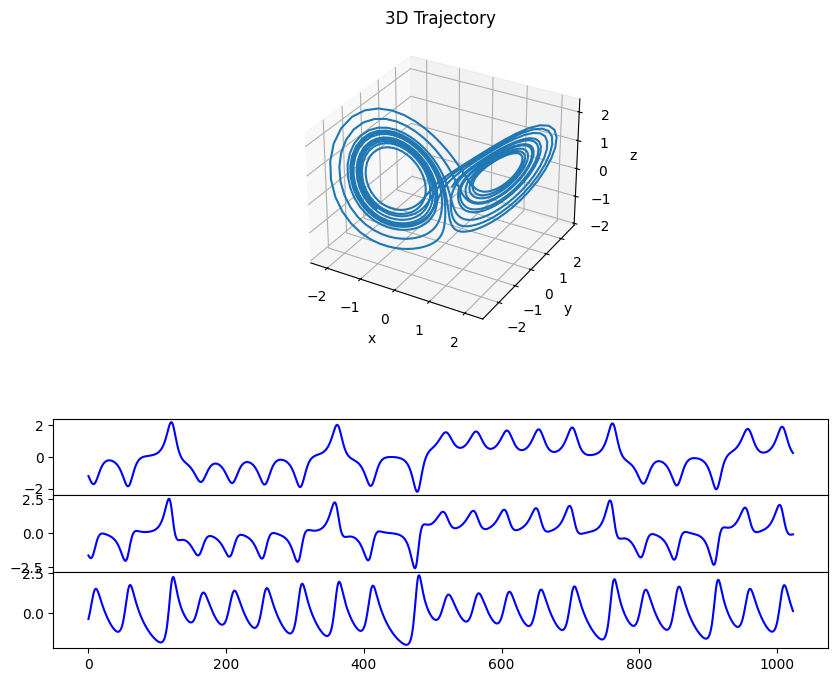

In [5]:
def plot_trajectory_with_coords(traj: np.ndarray, clip: float = None) -> None:
    """Plot 3D trajectory and individual coordinates.

    Args:
        traj: Trajectory array of shape (T, 3)
        clip: Optional float to clamp trajectory values between [-clip, clip]
    """
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    ax1 = fig.add_subplot(gs[0], projection="3d")
    ax1.plot(traj[:, 0], traj[:, 1], traj[:, 2])
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("z")
    ax1.set_title("3D Trajectory")

    # Bottom row - individual coordinates with shared x axis
    t = np.arange(len(traj))
    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    axes = []

    # For each coordinate, plot full range and clipped version if clip provided
    for i, (ax, label) in enumerate(
        [(gs_bot[0], "x"), (gs_bot[1], "y"), (gs_bot[2], "z")]
    ):
        ax_i = fig.add_subplot(ax, sharex=axes[0] if i > 0 and axes else None)
        axes.append(ax_i)
        coord = traj[:, i]
        ax_i.plot(t, coord, color="blue")


traj -= traj.mean(axis=0)
traj /= traj.std(axis=0)
plot_trajectory_with_coords(traj)

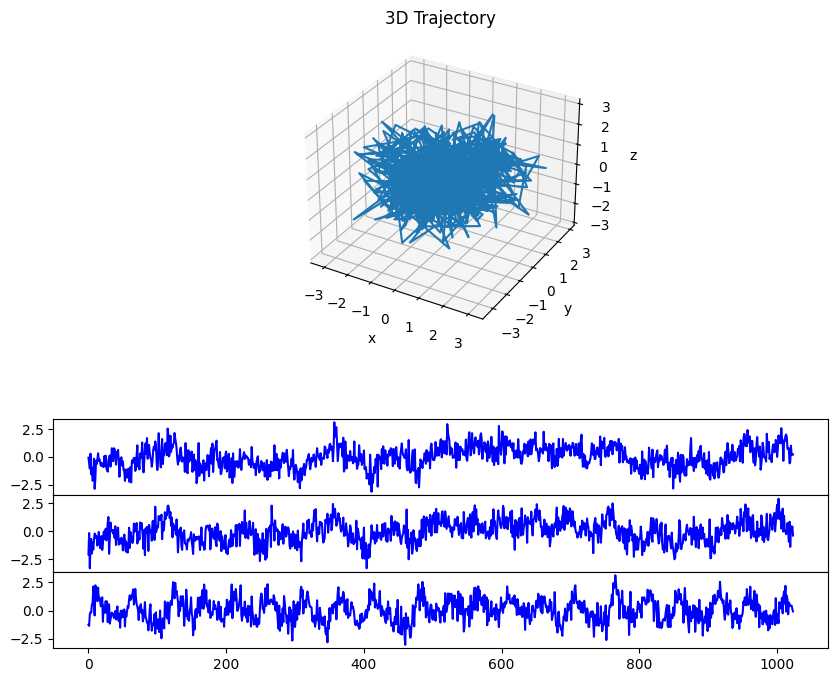

In [8]:
def noise_traj(traj: np.ndarray, scale: float = 0.1) -> np.ndarray:
    """Add Gaussian noise to trajectory data.

    Args:
        traj: Trajectory array of shape (T, 3)
        scale: Standard deviation of Gaussian noise

    Returns:
        Noisy trajectory array of same shape as input
    """
    noised = traj + scale * np.random.randn(*traj.shape)
    noised /= noised.std(axis=0)
    return noised


noisy_traj = noise_traj(traj, scale=1.0)
plot_trajectory_with_coords(noisy_traj)


In [9]:
def animate_noise_trajectory(
    traj: np.ndarray, scale_min: float = 0.0, scale_max: float = 1.0, n_steps: int = 20
) -> None:
    """Animate trajectory with increasing noise levels.

    Args:
        traj: Clean trajectory array of shape (T, 3)
        scale_min: Minimum noise scale
        scale_max: Maximum noise scale
        n_steps: Number of noise levels to show
    """
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    ax3d = fig.add_subplot(gs[0], projection="3d")
    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    axes = [fig.add_subplot(gs_bot[i]) for i in range(3)]

    # Plot original trajectory in gray
    ax3d.plot(traj[:, 0], traj[:, 1], traj[:, 2], color="gray", alpha=0.3)
    t = np.arange(len(traj))
    for i, ax in enumerate(axes):
        ax.plot(t, traj[:, i], color="gray", alpha=0.3)

    # Create animated lines
    line_3d = ax3d.plot([], [], [])[0]
    lines_coords = [ax.plot([], [], [])[0] for ax in axes]

    # Pre-compute axis limits including noise
    scales = np.linspace(scale_min, scale_max, n_steps)
    all_noisy = [noise_traj(traj, scale) for scale in scales]
    x_min = min(n[:, 0].min() for n in all_noisy)
    x_max = max(n[:, 0].max() for n in all_noisy)
    y_min = min(n[:, 1].min() for n in all_noisy)
    y_max = max(n[:, 1].max() for n in all_noisy)
    z_min = min(n[:, 2].min() for n in all_noisy)
    z_max = max(n[:, 2].max() for n in all_noisy)

    # Set axis limits
    ax3d.set_xlim(x_min, x_max)
    ax3d.set_ylim(y_min, y_max)
    ax3d.set_zlim(z_min, z_max)

    for ax in axes:
        ax.set_xlim(0, len(traj))
        ax.set_ylim(min(x_min, y_min, z_min), max(x_max, y_max, z_max))

    def init():
        line_3d.set_data([], [])
        line_3d.set_3d_properties([])
        for line in lines_coords:
            line.set_data([], [])
        return [line_3d] + lines_coords

    def update(frame):
        scale = scales[frame]
        noisy = noise_traj(traj, scale)

        line_3d.set_data(noisy[:, 0], noisy[:, 1])
        line_3d.set_3d_properties(noisy[:, 2])

        for i, line in enumerate(lines_coords):
            line.set_data(t, noisy[:, i])

        ax3d.set_title(f"Noisy Trajectory (scale={scale:.2f})")
        return [line_3d] + lines_coords

    # Set axis labels
    ax3d.set_xlabel("x")
    ax3d.set_ylabel("y")
    ax3d.set_zlabel("z")

    for i, (ax, label) in enumerate(zip(axes, ["x", "y", "z"])):
        ax.set_ylabel(label)
        if i < 2:
            ax.set_xticks([])
    axes[-1].set_xlabel("Time")

    from matplotlib.animation import FuncAnimation

    anim = FuncAnimation(
        fig, update, frames=n_steps, init_func=init, interval=200, blit=True
    )

    plt.close()
    return anim


# Create and display animation
anim = animate_noise_trajectory(traj, scale_min=0.0, scale_max=2.0, n_steps=20)
from IPython.display import HTML

HTML(anim.to_jshtml())

In [ ]:
anim.save("noise.gif")